# Exploratory Data Analysis (EDA) 

In [1]:
# TO DO: fix requirements.txt file 
# Vectorize procedures in utils scripts
# Something is iffy with nltk and stopwords being loaded several times
# Remember that virtual environment is salary_env

In [2]:
# Standard library imports 
import os
import sys 

# Third-party imports 
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Local imports 
import utils.preprocessor as mf
import utils.plotting as pf
import utils.text_parser as tf
import utils.salary_extractor as sf
import utils.dictionaries as dicts

# Activate autoreload for custom modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

# File path definitions
DATA_PATH = os.getenv('DATA_PATH', 'data/') 
MISSING = os.path.join(DATA_PATH, 'df_FRA_missing_data.csv')
         
COUNTRIES = ['Sweden', 'France', 'Italy']

[nltk_data] Downloading package punkt to /Users/emmafrid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emmafrid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Check we're in the right environment
print(sys.executable)

/Users/emmafrid/Documents/GitHub/portfolio-projects/job-listings-scraper/salary_env/bin/python


## Load data
Import the data scraped using scraper-countries.py (Sept 20-21 2024), for the following countries: USA, Sweden, France, and Italy. These datasets contain the job listings for the 3 largest cities in respective country, for the job titles _Data Scientist_, _Data Analyst_, _Product Analyst_, and _BI Analyst_.

In [4]:
# Import csv files with scraped data for resp. country 
dfs = {country: pd.read_csv(os.path.join(DATA_PATH, f'indeed_jobs_{country}.csv')) for country in COUNTRIES}

# Add USA data to the dictionary
dfs['USA'] = mf.merge_US_cities(['NY', 'LA', 'CHI'], os.path.join(DATA_PATH, 'indeed_jobs_'))

# Access individual country data as needed, e.g., dfs['Sweden']

Loaded data for NY
Column order for consistency: ['page', 'country', 'job_link', 'search_keyword', 'search_location', 'job_title', 'company_name', 'company_location', 'salary', 'job_description']


## Initial data inspection

In [5]:
dfs['Sweden'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data+Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,Not available,Data Analyst (Data Visualization) \n \n Swediu...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data+Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,Not available,Role: \n \n Website Performance: Web analyst f...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data+Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities \n \n Website Performance: W...
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description \n Statistics show that w...
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data+Analyst,Stockholm,"Juniora Analysts till Operations, Engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning \n \n \n Deloitte är en g...


In [6]:
dfs['France'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...


In [7]:
dfs['Italy'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Business Intelligence (Power BI) - Python- Bus...,Area IT Group,"Roma, Lazio",25.000 € - 40.000 € all'anno,Ricerchiamo Sviluppatori in almeno uno dei seg...
1,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Power Bi Analyst,Verisure Italy,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
2,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",IT Project Management Internship,Procter & Gamble,"Roma, Lazio",Not available,Job Location Rome Job Description INFORMATI...
3,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Credit & Collection Data Analyst,Verisure Italy S R L,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
4,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Aeronautical System Analyst,adecco,"Roma, Lazio",Not available,Per azienda leader a livello globale nella ges...


In [8]:
dfs['USA'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,USA,https://www.indeed.com/rc/clk?jk=5bf7eb172149d...,Data+Analyst,"New+York, NY",Business Analyst (Data products),Aon,"Remote in New York, NY","$80,000 - $95,000 a year - Full-time","Senior Associate Consultant, Data Solutions ..."
1,1,USA,https://www.indeed.com/rc/clk?jk=6b99bd10f1316...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone,"New York, NY",$32.38 - $39.01 an hour - Temporary,NYU Grossman School of Medicine is one of the...
2,1,USA,https://www.indeed.com/rc/clk?jk=d70c515431fa2...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone Health,"New York, NY 10016","$67,771.14 - $75,000.00 a year - Full-time",NYU Grossman School of Medicine is one of the...
3,1,USA,https://www.indeed.com/rc/clk?jk=3aa26222eadd6...,Data+Analyst,"New+York, NY","Resy Marketing Data Analyst, Data and Analytics",Amex,"Hybrid work in New York, NY","$60,000 - $110,000 a year",You Lead the Way. We’ve Got Your Back. \n With...
4,1,USA,https://www.indeed.com/rc/clk?jk=3aa564ce173c8...,Data+Analyst,"New+York, NY",2025 University Graduate - Digital Strategy An...,Adobe,"New York, NY 10012","$53,900 - $101,450 a year - Full-time",Our Company Changing the world through digit...


### Check dimensions and data types

In [9]:
# Check dimensions of dfs 
shapes = pd.DataFrame({
   'Country': dfs.keys(),
   'Columns': [df.shape[1] for df in dfs.values()],
   'Rows': [df.shape[0] for df in dfs.values()]
})
print(shapes.to_string())

  Country  Columns  Rows
0  Sweden       10   320
1  France       10  2200
2   Italy       10   769
3     USA       10  1317


In [10]:
# Check data types
dfs['Sweden'].info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   page              320 non-null    int64 
 1   country           320 non-null    object
 2   job_link          320 non-null    object
 3   search_keyword    320 non-null    object
 4   search_location   320 non-null    object
 5   job_title         320 non-null    object
 6   company_name      320 non-null    object
 7   company_location  320 non-null    object
 8   salary            320 non-null    object
 9   job_description   320 non-null    object
dtypes: int64(1), object(9)
memory usage: 25.1+ KB


In [11]:
# Retrieve dictionary with preferred types 
# Convert object columns to strings to optimize performance
# Mixed columns with both numbers and strings should be kept as object, e.g.: company_location, salary, job_link
dicts.dtype_dict

{'page': 'int64',
 'country': 'string',
 'job_link': 'object',
 'search_keyword': 'category',
 'search_location': 'string',
 'job_title': 'string',
 'company_name': 'string',
 'company_location': 'object',
 'salary': 'object',
 'job_description': 'string'}

In [12]:
# Convert columns to preferred data type
dfs = {country: df.astype(dicts.dtype_dict) for country, df in dfs.items()}
# Verify
print(dfs['Sweden'].dtypes)

page                         int64
country             string[python]
job_link                    object
search_keyword            category
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [13]:
dfs['Sweden'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   page              320 non-null    int64   
 1   country           320 non-null    string  
 2   job_link          320 non-null    object  
 3   search_keyword    320 non-null    category
 4   search_location   320 non-null    string  
 5   job_title         320 non-null    string  
 6   company_name      320 non-null    string  
 7   company_location  320 non-null    object  
 8   salary            320 non-null    object  
 9   job_description   320 non-null    string  
dtypes: category(1), int64(1), object(3), string(5)
memory usage: 23.1+ KB


## Data Quality Assessment

Overall: 
- The following columns needs to be cleaned: _search_keyword, job_title, job_description, company_location_.   
- The _salary_ column should be split into separate columns, with min and max value.   
- Text data in column _job_description_ needs normalization. 

### Missing values

In [14]:
# The scraper labels cells as 'Not available' when there is no value. Change these to NaN. 
for country, df in dfs.items():
    dfs[country] = df.replace('Not available', np.nan)

nan_counts = {country: df.isnull().sum() for country, df in dfs.items()}

for country, counts in nan_counts.items():
   print(f'Missing values for {country}:\n{counts}\n')

Missing values for Sweden:
page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              183
job_description       0
dtype: int64

Missing values for France:
page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description      51
dtype: int64

Missing values for Italy:
page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              746
job_description       0
dtype: int64

Missing values for USA:
page                 0
country              0
job_link             0
search_keyword       0
search_location      0
job_title          

Salary data will be cleaned and examined in detail later. It makes sense that so many values are missing since few job listings actually included salary info. For now we do not drop these rows.

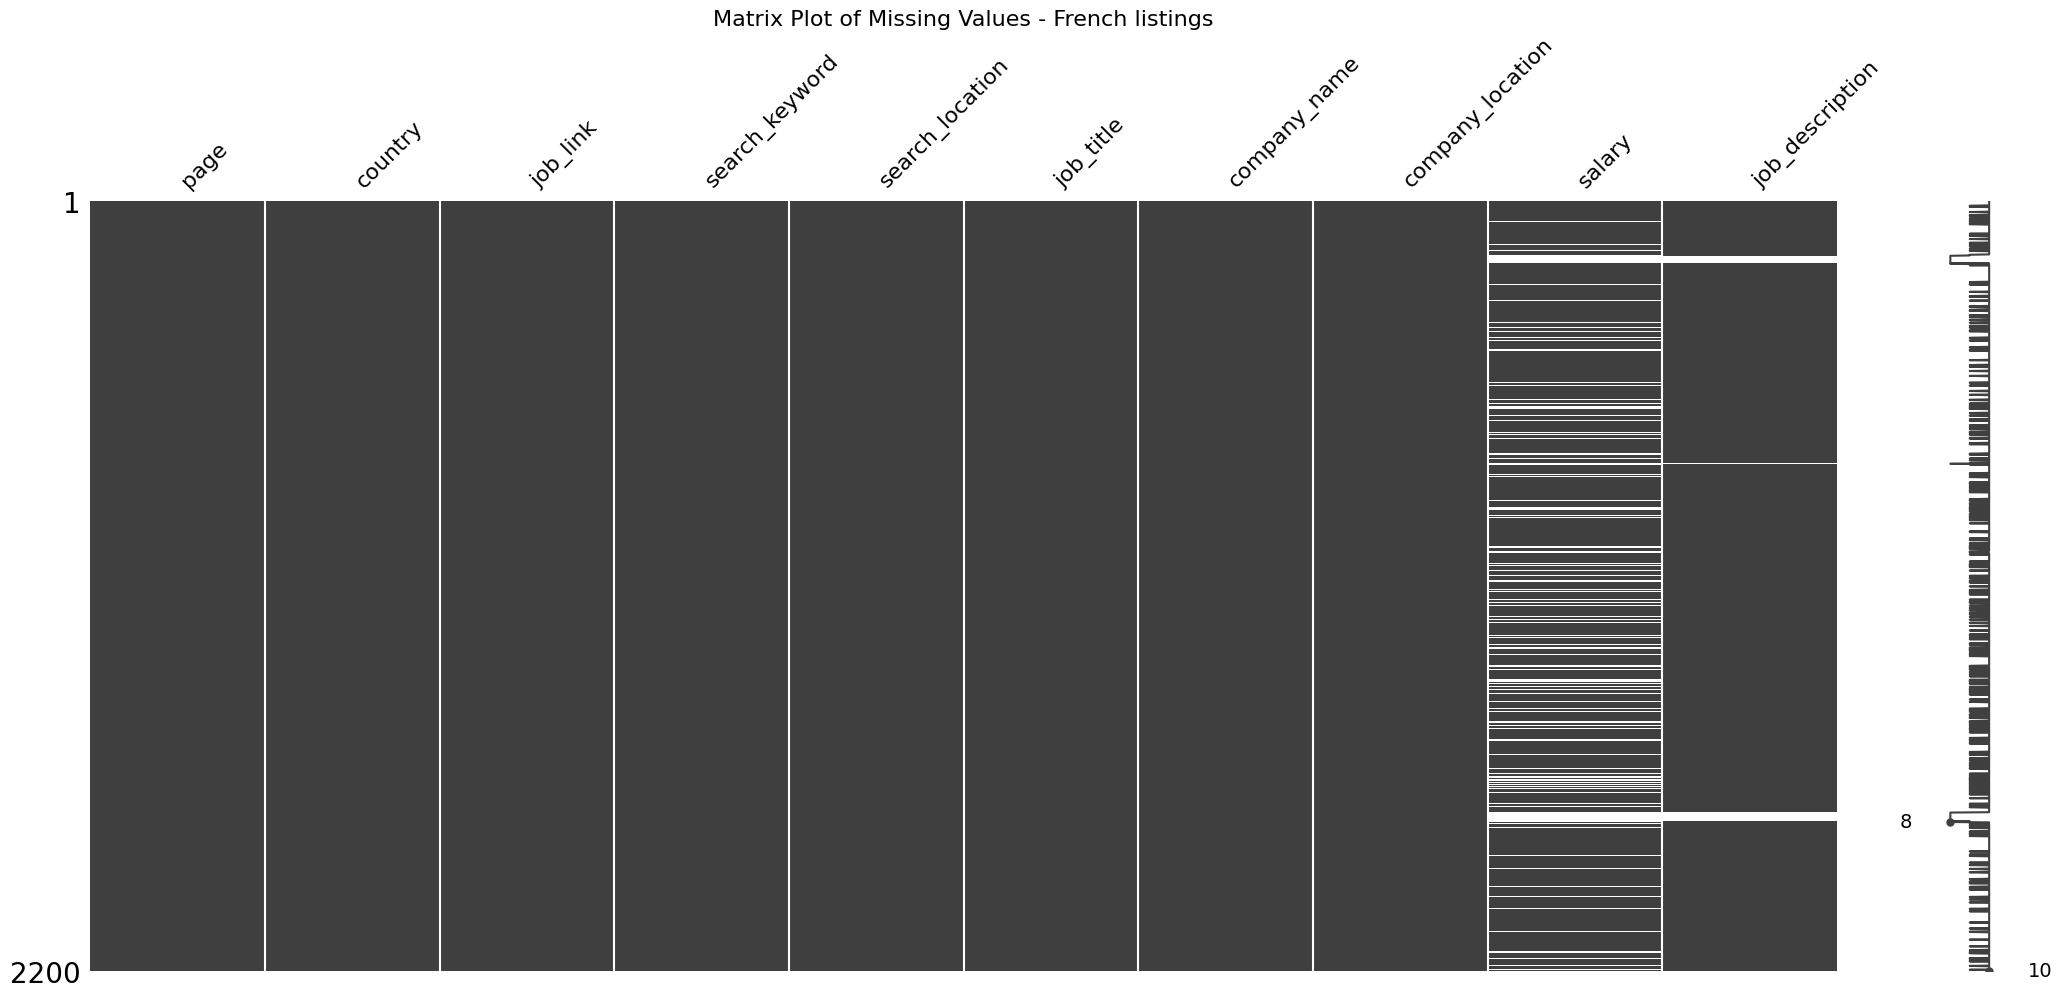

In [15]:
# Visualize missing data patterns 
msno.matrix(dfs['France']) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16) 
plt.show()

In [16]:
# Look into the missing descriptions for French job listings (scraper requests seems to have been blocked here?)
print(dfs['France'].isnull().sum())
#dfs['France'][dfs['France']['job_description'].isnull()].head()

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description      51
dtype: int64


In [17]:
# Manual import of missing job description data retrieved directly from URLs 
df_FRA_missing = pd.read_csv(MISSING)
df_FRA_missing.head(3)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description_new
0,11,France,https://www.indeed.fr/rc/clk?jk=cce878d76d9b30...,Data+Analyst,Paris (75),Business Analyst Customer Data 360 H/F,AIR FRANCE KLM,Roissy-en-France (95),CDI,Air France KLM recrute :\n\nVous rejoignez l'é...
1,11,France,https://www.indeed.fr/rc/clk?jk=56a9127952012f...,Data+Analyst,Paris (75),Senior Data Analyst - Paris,Aircall,Paris (75),NaN,Paris\nG&A – 13008 - Data /\nFull Time /\nHybr...
2,11,France,https://www.indeed.fr/rc/clk?jk=f43bcf87ea7bcd...,Data+Analyst,Paris (75),Marketing Business Analyst - (CDD 6 mois),Deliveroo,Paris (75),NaN,Why Deliveroo\n\nOur mission is to transform t...


In [18]:
# Merge French data frames based on the 'job_link' column (serves as unique identifier)
merged_df = pd.merge(dfs['France'], df_FRA_missing[['job_link', 'job_description_new']], on='job_link', how='left')
merged_df['job_description'] = merged_df['job_description'].fillna(merged_df['job_description_new'])
merged_df.drop(columns='job_description_new', inplace=True)
dfs['France'] = merged_df
# Verify that there are no missing values in 'job_description'
print(dfs['France'].isnull().sum())

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64


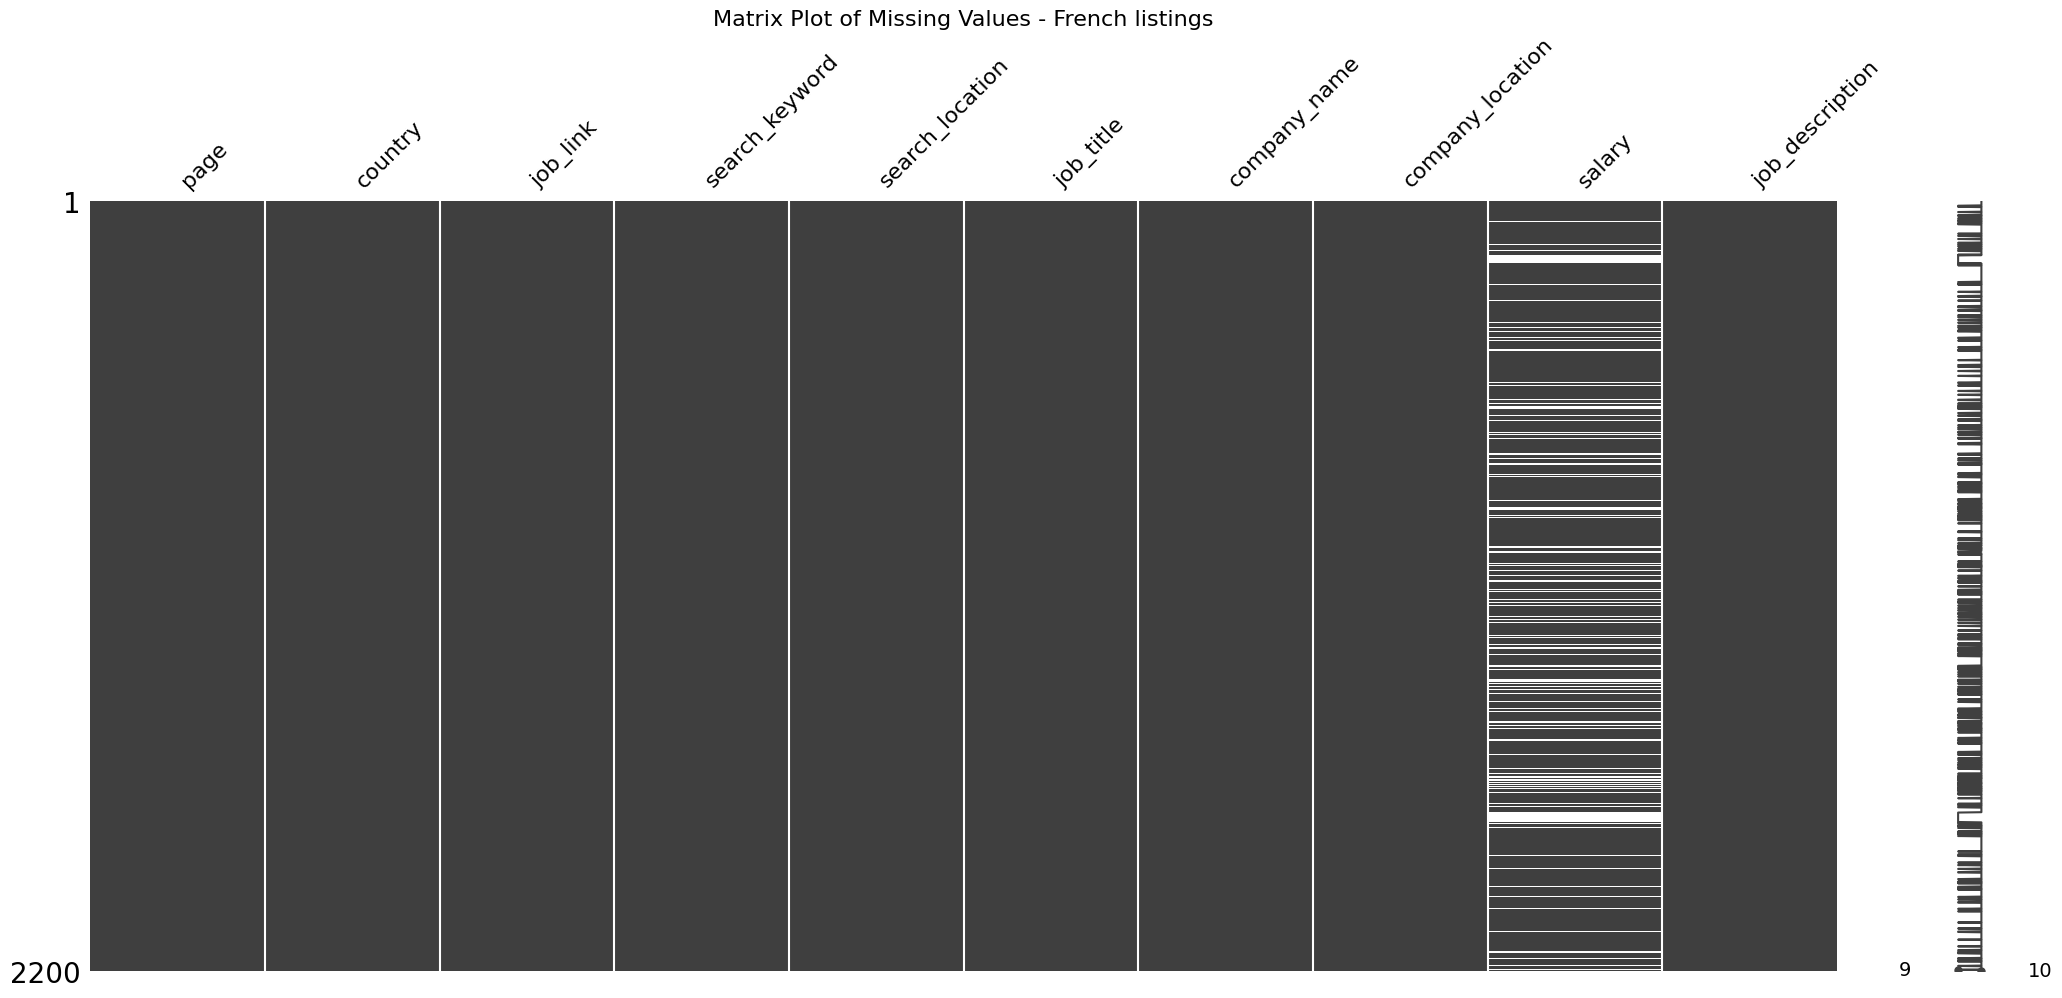

In [19]:
# Now the job_description should not have missing values anymore
msno.matrix(dfs['France'])
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16)  
plt.show()

In [20]:
# Verify consistent data types after the newly added info in job_description column
dfs['France'] = dfs['France'].astype(dicts.dtype_dict)
dfs['France'].dtypes

page                         int64
country             string[python]
job_link                    object
search_keyword            category
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object

### Check for duplicates

In [21]:
duplicate_counts = {country: mf.check_duplicates(df) for country, df in dfs.items()}
for country, counts in duplicate_counts.items():
   print(f'Duplicates for {country}:\n{counts}\n')

Duplicates for Sweden:
None

Duplicates for France:
None

Duplicates for Italy:
None

Duplicates for USA:
None



No rows are completely identical, but there are in fact numerous examples of completely identical job descriptions. These are likely _reposts_ (the same job appearing multiple times, just with different unique links). Remove these entries if the job titles are the same and the locations are the same. 

In [22]:
# Identify rows with same job title, location, and job description, and keep only the latest job listing
dfs = {country: mf.remove_duplicates_jobdesc(df) for country, df in dfs.items()}

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 3200. Size after removing duplicates: 2630 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 22000. Size after removing duplicates: 13650 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 7690. Size after removing duplicates: 5690 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 13170. Size after removing duplicates: 8350 



### Clean columns

In [23]:
# Clean search_keyword and search_location columns: replace '+' with ' ' 
dfs = {country: df.assign(
   search_keyword=pd.Categorical(df['search_keyword'].astype(str).str.replace('+', ' ')),
   search_location=pd.Categorical(df['search_location'].astype(str).str.replace('+', ' '))
) for country, df in dfs.items()}
# Verify that it worked 
dfs['Sweden'].head(3)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...
1,1,Sweden,https://se.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data Analyst,Stockholm,Fraud & Data Analyst to The Fraud Strategy & A...,Entercard Group AB,111 39 Stockholm,NaN,About Entercard Entercard is one of Scandin...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=27fb82edf82fcd...,Data Analyst,Stockholm,Data Analyst,Star Stable Entertainment,Distansjobb in 118 27 Stockholm,NaN,About Star Stable Entertainment Once upon a ...


In [24]:
# Clean job_title column 
dfs = {country: df.assign(
   job_title=df['job_title'].str.lower().pipe(
       lambda x: x.str.replace(r'\(?(h/f|f/h)\)?', '', regex=True).str.strip() 
       if country == 'France' else x
   )
) for country, df in dfs.items()}

In [25]:
# Merge all dfs in the dictionary into a single df
df_combined = pd.concat(dfs.values(), ignore_index=True)
df_combined.reset_index(drop=True, inplace=True)
# Add dates when data was scraped 
df_combined['date'] = np.where(df_combined['country'].isin(['Sweden', 'USA']), pd.to_datetime('2024-09-19'), pd.to_datetime('2024-09-20'))
df_combined.head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date
0,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,data analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,2024-09-19
1,1,Sweden,https://se.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data Analyst,Stockholm,fraud & data analyst to the fraud strategy & a...,Entercard Group AB,111 39 Stockholm,NaN,About Entercard Entercard is one of Scandin...,2024-09-19
2,1,Sweden,https://se.indeed.com/rc/clk?jk=27fb82edf82fcd...,Data Analyst,Stockholm,data analyst,Star Stable Entertainment,Distansjobb in 118 27 Stockholm,NaN,About Star Stable Entertainment Once upon a ...,2024-09-19
3,1,Sweden,https://se.indeed.com/rc/clk?jk=7fa39868401ee6...,Data Analyst,Stockholm,data analyst,Baby Journey AB,114 51 Stockholm,NaN,Baby Journey lanserades hösten 2020 och är en ...,2024-09-19
4,2,Sweden,https://se.indeed.com/rc/clk?jk=e8928767cb355b...,Data Analyst,Stockholm,oit-237 data classification and labeling analyst,WSP Sverige,111 20 Stockholm,NaN,WSP is a global consulting firm assisting pub...,2024-09-19


In [26]:
# Language Identification: identify the language of each job description (will take 1 minute!)
df_combined['language'] = df_combined['job_description'].apply(tf.detect_language)

In [27]:
# Assign job_id to each row, instead of using unique URLs as identifier
df_combined.insert(0, 'job_id', range(1, len(df_combined) + 1))
df_combined.head(3)

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language
0,1,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,data analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,2024-09-19,en
1,2,1,Sweden,https://se.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data Analyst,Stockholm,fraud & data analyst to the fraud strategy & a...,Entercard Group AB,111 39 Stockholm,NaN,About Entercard Entercard is one of Scandin...,2024-09-19,en
2,3,1,Sweden,https://se.indeed.com/rc/clk?jk=27fb82edf82fcd...,Data Analyst,Stockholm,data analyst,Star Stable Entertainment,Distansjobb in 118 27 Stockholm,NaN,About Star Stable Entertainment Once upon a ...,2024-09-19,en


In [28]:
# Normalize text data in job_description
normalized_descriptions = df_combined.groupby('language')[['job_description']].apply(tf.normalize_group)
normalized_descriptions = normalized_descriptions.reset_index()
df_combined = df_combined.reset_index(drop=True)
df_combined = pd.merge(df_combined, normalized_descriptions[['language', 'job_description', 'normalized_text']], on=['language', 'job_description'], how='left')

Normalizing text for language group: en
Normalizing text for language group: fr
Normalizing text for language group: it
Normalizing text for language group: sv


In [29]:
df_combined[['job_description', 'normalized_text']].head()

,job_description,normalized_text
0,Company Description Statistics show that wo...,company description statistic show woman under...
1,About Entercard Entercard is one of Scandin...,entercard entercard one scandinavia’s leading ...
2,About Star Stable Entertainment Once upon a ...,star stable entertainment upon time 2011 found...
3,Baby Journey lanserades hösten 2020 och är en ...,baby journey lanserades hösten 2020 app riktar...
4,WSP is a global consulting firm assisting pub...,wsp global consulting firm assisting public pr...


In [30]:
# Map language codes to full language names 
df_combined['language'] = df_combined['language'].map(dicts.language_map)

In [31]:
# Verify data types for new columns (compare to dicts.dtype_dict)
df_combined.dtypes

job_id                       int64
page                         int64
country             string[python]
job_link                    object
search_keyword            category
search_location             object
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
date                datetime64[ns]
language                    object
normalized_text             object
dtype: object

In [32]:
df_combined = df_combined.astype({
    'job_id': 'int64',
    'language': 'category',
    'normalized_text': 'string'
})
df_combined.dtypes

job_id                       int64
page                         int64
country             string[python]
job_link                    object
search_keyword            category
search_location             object
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
date                datetime64[ns]
language                  category
normalized_text     string[python]
dtype: object

In [33]:
df_combined.head(3)

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,normalized_text
0,1,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,data analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,2024-09-19,english,company description statistic show woman under...
1,2,1,Sweden,https://se.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data Analyst,Stockholm,fraud & data analyst to the fraud strategy & a...,Entercard Group AB,111 39 Stockholm,NaN,About Entercard Entercard is one of Scandin...,2024-09-19,english,entercard entercard one scandinavia’s leading ...
2,3,1,Sweden,https://se.indeed.com/rc/clk?jk=27fb82edf82fcd...,Data Analyst,Stockholm,data analyst,Star Stable Entertainment,Distansjobb in 118 27 Stockholm,NaN,About Star Stable Entertainment Once upon a ...,2024-09-19,english,star stable entertainment upon time 2011 found...


## Descriptive statistics

In [34]:
# Describe (numerical) columns  
mask = df_combined['country'] == 'Sweden'
df_combined[mask].describe(include='all').head()

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,normalized_text
count,263.0,263.000000,263,263,263,263,263,263,263,113,263,263,263,263
unique,NaN,NaN,1,263,4,3,194,198,88,10,263,NaN,2,263
top,NaN,NaN,Sweden,https://se.indeed.com/rc/clk?jk=132e951bba6ac1...,Data Scientist,Stockholm,systemutvecklare,Cubane Solutions AB,Stockholm,Heltid,We are hiring a GIS Analyst Nordregio is exp...,NaN,english,hiring gi analyst nordregio expanding gi team ...
freq,NaN,NaN,263,1,131,186,19,7,69,58,1,NaN,133,1
mean,132.0,2.593156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-19 00:00:00,NaN,NaN


In [35]:
# Describe categorical columns  
mf.desc_categorical(df_combined[mask])

Value counts for column: country
country
Sweden    263
Name: count, dtype: Int64

Value counts for column: job_title
job_title
systemutvecklare                                 19
data analyst                                     13
data scientist                                   13
business analyst                                  8
senior data scientist                             5
                                                 ..
pricing coordinator                               1
senior business intelligence analyst              1
senior logistics analyst                          1
powerbi utvecklare                                1
production analytics lead [game intelligence]     1
Name: count, Length: 194, dtype: Int64

Value counts for column: company_name
company_name
Cubane Solutions AB      7
Deploja AB               6
JobBusters AB            4
Volvo Group              4
TEN10 AB                 4
                        ..
Techster Solutions       1
JAS Worldwide        

### Preliminary observations, Swedish job listings:
- __Most frequent job titles__: Systemutvecklare, Data Analyst, Data Scientist.
- __Most frequent company__: Cubane Solutions AB. 
- __Company location__: Stockholm primarily. 
- __Salary ranges__: Few numerical values are provided.

In [36]:
mask = df_combined['country'] == 'France'
df_combined[mask].describe(include='all').head(4)

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,normalized_text
count,1392.0,1392.0,1392,1392,1392,1392,1392,1392,1392,1125,1392,1392,1392,1392
unique,NaN,NaN,1,1365,4,3,1153,717,256,164,1355,NaN,2,1340
top,NaN,NaN,France,https://www.indeed.fr/rc/clk?jk=87348216f5b0a7...,Product Analyst,Paris (75),data analyst,AXA,Paris (75),Temps plein,Line of Service Advisory \n \n Industry/Sect...,NaN,french,line of service advisory industry/sector not a...
freq,NaN,NaN,1392,4,510,1215,38,37,385,316,16,NaN,1008,16


In [37]:
mf.desc_categorical(df_combined[mask]) 

Value counts for column: country
country
France    1392
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data analyst                                                                                            38
data scientist                                                                                          32
business analyst                                                                                        13
business analyst data                                                                                    8
data analyst intern                                                                                      8
                                                                                                        ..
data analyst junior                                                                                      1
cdi - online business analyst                                                                            1
stage - junior b

### Preliminary observations, French job listings:
- Many listings compared to Sweden. 
- __Most frequent job titles__: Data Analyst (many similar names for this title, e.g. Data Analyst H/F and Data Analyst Intern). 
- __Most frequently mentioned company__: Essity.
- __Company location__: Most in Paris. 
- __Salary ranges__: Need to split column to be able to draw any conclusions.

In [38]:
mask = df_combined['country'] == 'Italy'
df_combined[mask].describe(include='all').head(4)

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,normalized_text
count,602.0,602.0,602,602,602,602,602,602,602,20,602,602,602,602
unique,NaN,NaN,1,569,4,3,454,309,96,14,554,NaN,3,552
top,NaN,NaN,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data Analyst,"Milano, Lombardia",data scientist,BIP - Business Integration Partners,"Milano, Lombardia",52.246 € all'anno,"NTT DATA, Trusted Global Innovator, è tra i pr...",NaN,italian,ntt data trusted global innovator è tra princi...
freq,NaN,NaN,602,3,264,407,35,44,153,5,9,NaN,334,9


In [39]:
mf.desc_categorical(df_combined[mask])

Value counts for column: country
country
Italy    602
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data scientist                                         35
data analyst                                           19
business analyst                                       11
azure data engineer                                     9
senior data analyst                                     8
                                                       ..
junior business analyst autohero                        1
process & data management analyst junior                1
kpmg open platform | risk - security senior analyst     1
crm analyst                                             1
demand planner - confectionery                          1
Name: count, Length: 454, dtype: Int64

Value counts for column: company_name
company_name
BIP - Business Integration Partners    44
NTT Data                               16
KPMG                                   14
NTT DATA ITALIA S.P

### Preliminary observations, Italian job listings:
- Many listings compared to Sweden, but less than France.
- __Most frequent job titles__: Data Scientist.
- __Most frequently mentioned company__: BIP - Business Integration Partners. 
- __Company location__: Milano. Also remote in Milano is relatively common (as is Rome).
- __Salary ranges__: Few numerical entries provided. 

In [40]:
mask = df_combined['country']=='USA'
df_combined[mask].describe(include='all').head(4)

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,normalized_text
count,859.0,859.0,859,859,859,859,859,859,859,813,859,859,859,859
unique,NaN,NaN,1,835,4,3,737,470,185,524,823,NaN,1,823
top,NaN,NaN,USA,https://www.indeed.com/rc/clk?jk=81b688a182f31...,BI Analyst,"New York, NY",data analyst,Citi,"New York, NY",Full-time,Wavemaker positively provokes growth for clien...,NaN,english,wavemaker positively provokes growth client re...
freq,NaN,NaN,859,2,276,498,12,27,184,150,4,NaN,859,4


In [41]:
mf.desc_categorical(df_combined[mask])

Value counts for column: country
country
USA    859
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data analyst                                                   12
business analyst                                               11
senior machine learning engineer                                9
senior data scientist                                           8
senior business analyst                                         5
                                                               ..
sales analyst                                                   1
healthcare claims api/edi business analyst (local) (hybrid)     1
ecommerce analyst                                               1
senior financial analyst, north america commercial finance      1
business analyst, performance internal controls                 1
Name: count, Length: 737, dtype: Int64

Value counts for column: company_name
company_name
Citi                        27
JPMorganChase               

### Preliminary observations, American job listings:
- Number of listings are less than for France. 
- __Most frequent job titles__: Data Analyst, BI analyst.... Interesting that Machine Learning Engineer shows up. Might need to cluster similar terms to get the full picture. 
- __Most frequently mentioned company__: Citi. 
- __Company location__: New York.  
- __Salary ranges__: Need to split column to draw conclusions. 

## Feature engineering 

### Retrieve numeric values for salary

In [163]:
for country in df_combined['country'].unique():
    mask = df_combined['country'] == country
    unique_langs = df_combined[mask]['language'].unique().tolist()
    print('*' * 30) 
    print(f'Retrieving salaries for {country}:')
    #print(f'Languages: {unique_langs}    8vc                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 dfjpxhio4')
    result = sf.parse_salary_column(df_combined[mask], languages=unique_langs, country=country)
        
    assert result.size==df_combined[mask].size
    columns_to_update = ['min_salary', 'max_salary', 'currency', 'time_unit']
    df_combined.loc[mask, columns_to_update] = result[columns_to_update]
    
    print('*' * 30 + '\n')

# After the loop, convert the columns to categorical
currency_categories = ['dollar', 'euro', 'sek']
time_unit_categories = ['year', 'month', 'week', 'hour', 'day']

df_combined['currency'] = df_combined['currency'].astype(pd.CategoricalDtype(categories=currency_categories, ordered=False))
df_combined['time_unit'] = df_combined['time_unit'].astype(pd.CategoricalDtype(categories=time_unit_categories, ordered=False))

******************************
Retrieving salaries for Sweden:
     min_salary  max_salary
110     40000.0     80000.0
221     15000.0     20000.0
******************************

******************************
Retrieving salaries for France:
265           de 721 € à 1 747 € par mois  -   alternance
285     de 38 452,41 € à 50 000,00 € par an  -   cdi, ...
290           de 800 € à 1 500 € par mois  -   alternance
294     de 45 000 € à 55 000 € par an  -   cdi, temps ...
296                 33 000 € par an  -   cdi, temps plein
                              ...                        
1625    à partir de 35 000 € par an  -   cdi, temps plein
1627       de 35 000 € à 45 000 € par an  -   temps plein
1637    de 42 000 € à 48 000 € par an  -   cdi, temps ...
1639    de 45 000 € à 55 000 € par an  -   cdi, temps ...
1640               de 40 000 € à 55 000 € par an  -   cdi
Name: salary, Length: 155, dtype: object


ValueError: could not convert string to float: '1\xa0747'

In [147]:
print('Sample of updated data:')
print(df_combined[df_combined['salary'].notna()][['country', 'salary', 'min_salary', 'max_salary', 'currency', 'time_unit']].sample(10))

Sample of updated data:
     country                                          salary  min_salary  \
2986     USA       $225,000 - $275,000 a year  -   Full-time    225000.0   
1588  France          De 50 000 € à 56 000 € par an  -   CDI        <NA>   
1468  France              Courte durée jusqu'à 6 mois, Stage        <NA>   
2915     USA                      $130,800 - $222,500 a year    130800.0   
3008     USA                                       Full-time        <NA>   
2804     USA         $7,624 - $10,274 a month  -   Full-time      7624.0   
184   Sweden                                     Tillsvidare        <NA>   
3097     USA                                       Full-time        <NA>   
1479  France  De 1 100 € à 1 300 € par mois  -   Temps plein        <NA>   
2618     USA                 $82,872.00 - $145,540.50 a year     82872.0   

      max_salary currency time_unit  
2986    275000.0   dollar      year  
1588        <NA>     euro      year  
1468        <NA>      NaN

In [116]:
df_combined[(df_combined['country'] == 'France') & (df_combined['min_salary'].notna())].head()

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,normalized_text,min_salary,max_salary,currency,time_unit,min_salary_monthly
265,266,3,France,https://www.indeed.fr/rc/clk?jk=8a827ea3e37c59...,Data Analyst,Paris (75),alternance - assistant data analyst,CMI France,Télétravail partiel à 92300 Levallois-Perret,De 721 € à 1 747 € par mois - Alternance,"CMI Media, la régie publicitaire du groupe CMI...",2024-09-20,french,cmi medium régie publicitaire groupe cmi franc...,721.0,747.0,euro,month,721.0
285,286,8,France,https://www.indeed.fr/rc/clk?jk=170951741428ce...,Data Analyst,Paris (75),business data analyst,Lucky Cart,75002 Paris 2e,"De 38 452,41 € à 50 000,00 € par an - CDI, ...",Descriptif du poste La forte croissance que ...,2024-09-20,french,descriptif poste forte croissance enregistrons...,38.0,0.0,euro,year,3204.333333
290,291,9,France,https://www.indeed.fr/rc/clk?jk=1bc979f290dd06...,Data Analyst,Paris (75),alternant data analyst en business intelligence,HEC Paris,78350 Jouy-en-Josas,De 800 € à 1 500 € par mois - Alternance,L'institut entreprenariat et innovation HEC pa...,2024-09-20,french,l'institut entreprenariat innovation hec paris...,800.0,500.0,euro,month,800.0
294,295,10,France,https://www.indeed.fr/rc/clk?jk=264334b84cfb7d...,Data Analyst,Paris (75),business analyst,Garance,Télétravail partiel à 75009 Paris 9e,"De 45 000 € à 55 000 € par an - CDI, Temps ...",Vous recherchez des missions variées au sein d...,2024-09-20,french,recherchez mission variées sein entreprise inn...,45.0,0.0,euro,year,3750.0
296,297,11,France,https://www.indeed.fr/rc/clk?jk=556c1db505f967...,Data Analyst,Paris (75),data analyst,IONIS Education Group,Le Kremlin-Bicêtre (94),"33 000 € par an - CDI, Temps plein",Publiée le 22/07/2024 Etablissem...,2024-09-20,french,publiée 22/07/2024 etablissement epita type c...,33.0,0.0,euro,year,2750.0


In [117]:
# Check the actual salary differences
comparison = pd.merge(df_combined[mask][['job_id', 'salary']], result[['job_id', 'min_salary']], on='job_id')
missed_parsing = comparison[comparison['salary'].notna() & comparison['min_salary'].isna()][['job_id', 'salary']]
missed_parsing.to_csv('missed_salaries.csv', index=False)

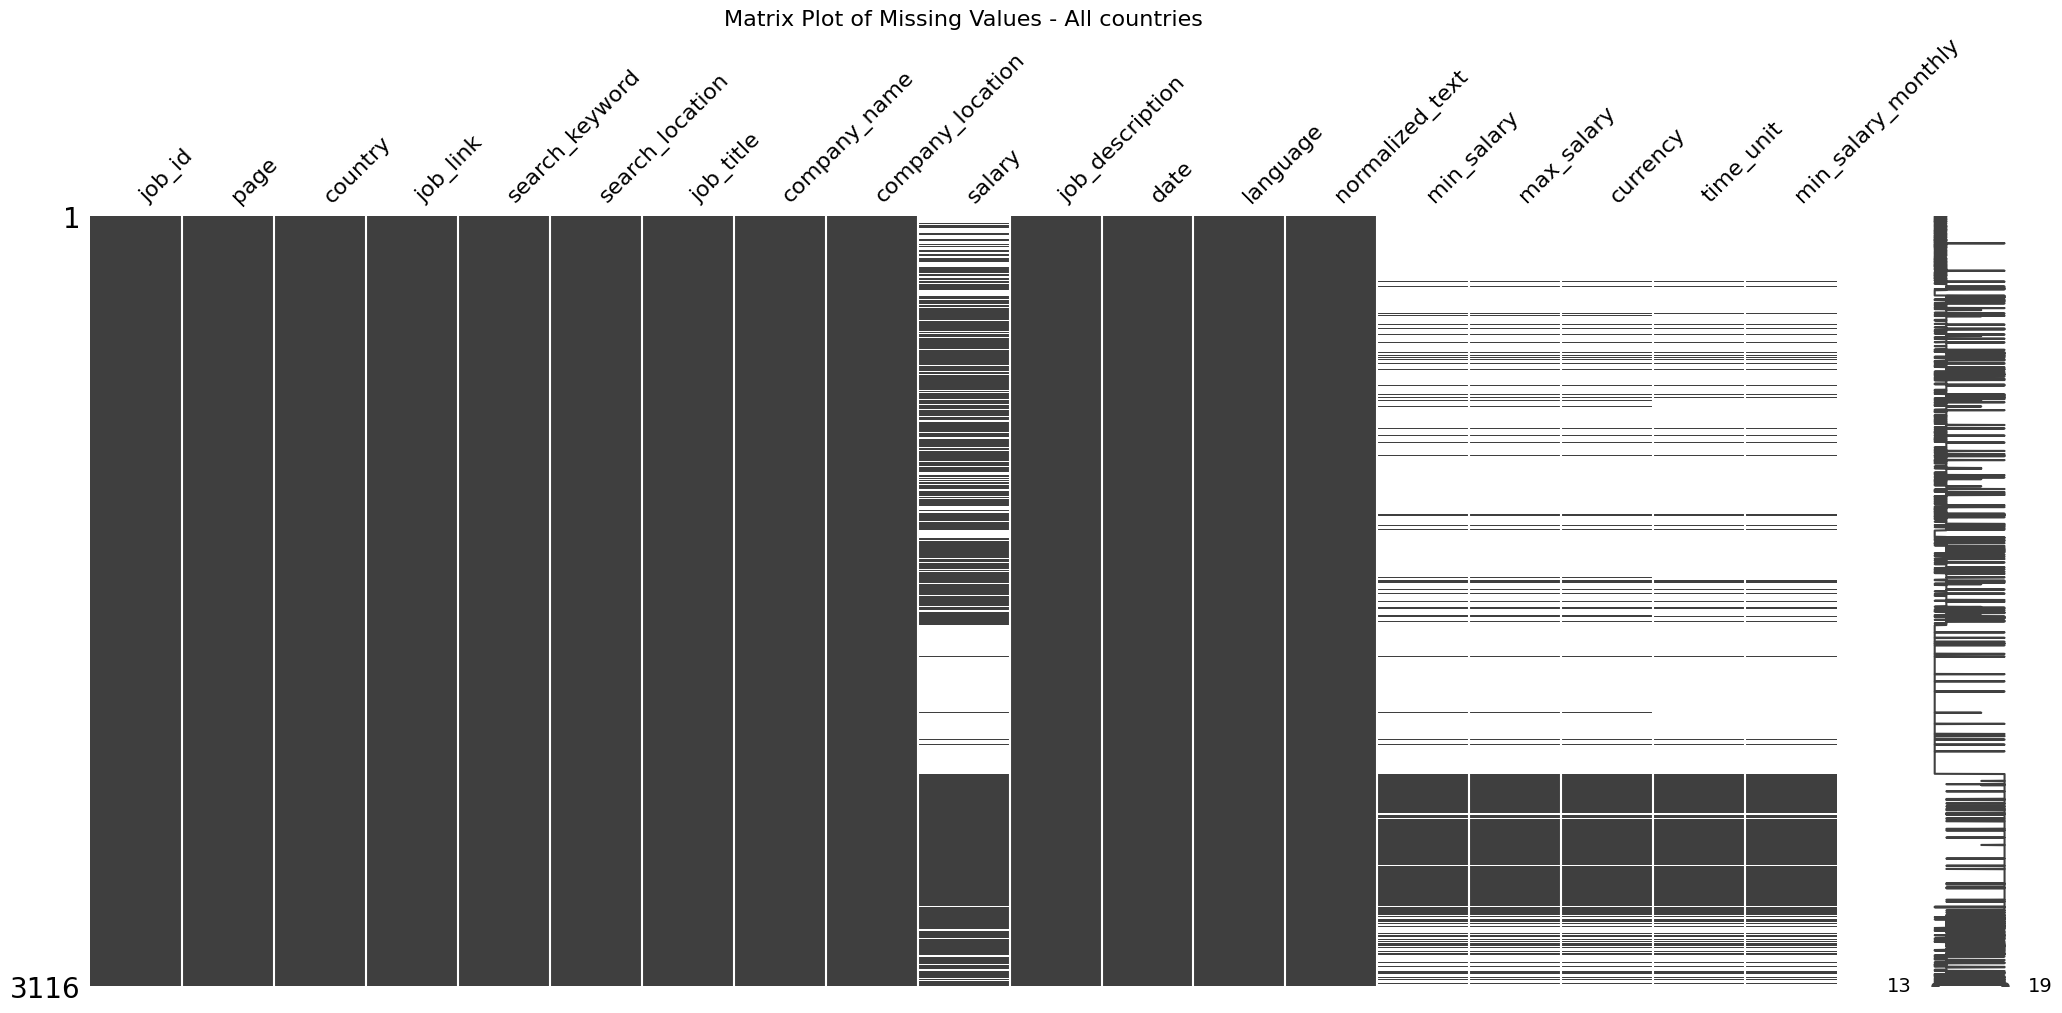

In [118]:
# Check missing values now 
msno.matrix(df_combined)
plt.title('Matrix Plot of Missing Values - All countries', fontsize=16)  
plt.show()

In [119]:
# Make sure data types are correct again
df_combined.dtypes

job_id                         int64
page                           int64
country               string[python]
job_link                      object
search_keyword              category
search_location               object
job_title             string[python]
company_name          string[python]
company_location              object
salary                        object
job_description       string[python]
date                  datetime64[ns]
language                    category
normalized_text       string[python]
min_salary                   Float64
max_salary                   Float64
currency                    category
time_unit                   category
min_salary_monthly           Float64
dtype: object

In [120]:
# Standardize salary to be per month
sek_to_eur = sf.get_exchange_rate('SEK', 'EUR')
usd_to_eur = sf.get_exchange_rate('USD', 'EUR')

print(f"The exchange rate from SEK to EUR is: {sek_to_eur}")
print(f"The exchange rate from USD to EUR is: {usd_to_eur}")

The exchange rate from SEK to EUR is: 0.08656
The exchange rate from USD to EUR is: 0.96043


In [121]:
df_combined['min_salary_monthly'] = sf.convert_salary_to_monthly(df_combined, 'min_salary', 'time_unit')
df_combined[df_combined['min_salary_monthly'].notna()]

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,normalized_text,min_salary,max_salary,currency,time_unit,min_salary_monthly
110,111,1,Sweden,https://se.indeed.com/rc/clk?jk=044708271c5bec...,Data Scientist,Göteborg,senior data scientist som vill skapa framtida ...,Artificial Collective,413 27 Göteborg,40 000SEK - 80 000SEK per månad,Hej! Är du redo att göra verklig skillnad m...,2024-09-19,swedish,hej redo göra verklig skillnad ai artificial c...,40000.0,80000.0,sek,month,40000.0
221,222,1,Sweden,https://se.indeed.com/rc/clk?jk=3daeeaf597909e...,Product Analyst,Malmö,swedish customer support analyst - bulgaria ba...,TELUS International Europe,Lund,15 000SEK - 20 000SEK per månad - Tillsvida...,*Please note that the position is based in Sof...,2024-09-19,english,please note position based sofia bulgaria help...,15000.0,20000.0,sek,month,15000.0
265,266,3,France,https://www.indeed.fr/rc/clk?jk=8a827ea3e37c59...,Data Analyst,Paris (75),alternance - assistant data analyst,CMI France,Télétravail partiel à 92300 Levallois-Perret,De 721 € à 1 747 € par mois - Alternance,"CMI Media, la régie publicitaire du groupe CMI...",2024-09-20,french,cmi medium régie publicitaire groupe cmi franc...,721.0,747.0,euro,month,721.0
285,286,8,France,https://www.indeed.fr/rc/clk?jk=170951741428ce...,Data Analyst,Paris (75),business data analyst,Lucky Cart,75002 Paris 2e,"De 38 452,41 € à 50 000,00 € par an - CDI, ...",Descriptif du poste La forte croissance que ...,2024-09-20,french,descriptif poste forte croissance enregistrons...,38.0,0.0,euro,year,3.166667
290,291,9,France,https://www.indeed.fr/rc/clk?jk=1bc979f290dd06...,Data Analyst,Paris (75),alternant data analyst en business intelligence,HEC Paris,78350 Jouy-en-Josas,De 800 € à 1 500 € par mois - Alternance,L'institut entreprenariat et innovation HEC pa...,2024-09-20,french,l'institut entreprenariat innovation hec paris...,800.0,500.0,euro,month,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3105,3022,7,USA,https://www.indeed.com/rc/clk?jk=e87163ba51fcb...,BI Analyst,"Chicago, IL",mdm analyst,FreshEdge,"Chicago, IL","$90,000 - $95,000 a year",FreshEdge is built on a united infrastructur...,2024-09-19,english,freshedge built united infrastructure fresh fo...,90000.0,95000.0,dollar,year,7500.0
3106,3023,7,USA,https://www.indeed.com/rc/clk?jk=037e31a22f28b...,BI Analyst,"Chicago, IL",collection letter business analyst,Harris & Harris,"Chicago, IL 60604","$60,000 - $70,000 a year",Harris & Harris has over 50 years of experienc...,2024-09-19,english,harris harris 50 year experience customer car...,60000.0,70000.0,dollar,year,5000.0
3107,3024,7,USA,https://www.indeed.com/rc/clk?jk=2ee475dcae1ca...,BI Analyst,"Chicago, IL",senior itsm analyst (hybrid chicagoland),Camping World,"Hybrid work in Chicago, IL 60606","$98,490.00 - $147,787.50 a year - Full-time",We are seeking a proactive and experienced ITS...,2024-09-19,english,seeking proactive experienced itsm service del...,98490.0,147787.5,dollar,year,8207.5
3111,3028,7,USA,https://www.indeed.com/rc/clk?jk=9c6fd220bf26f...,BI Analyst,"Chicago, IL",healthcare claims api/edi business analyst (lo...,RelMap Software,"Rosemont, IL","$70 - $80 an hour - Full-time, Contract",MUST BE LOCAL TO THE CHICAGO-AREA. IN-PERSON I...,2024-09-19,english,must local chicago-area in-person interview re...,70.0,80.0,dollar,hour,11200.0


In [ ]:
df_combined[df_combined['min_salary_monthly'].notna()]

In [ ]:
# Convert salary to same currency using exchange rate
df_combined.loc[(df_combined['currency'] == 'SEK') & (df_combined['min_salary_month'].notna()), 'min_salary_month_EUR'] = df_combined['min_salary_month'] * sek_to_eur
df_combined.loc[(df_combined['currency'] == 'SEK') & (df_combined['max_salary_month'].notna()), 'max_salary_month_EUR'] = df_combined['max_salary_month'] * sek_to_eur

df_combined.loc[(df_combined['currency'] == 'USD') & (df_combined['min_salary_month'].notna()), 'min_salary_month_EUR'] = df_combined['min_salary_month'] * usd_to_eur
df_combined.loc[(df_combined['currency'] == 'USD') & (df_combined['max_salary_month'].notna()), 'max_salary_month_EUR'] = df_combined['max_salary_month'] * usd_to_eur

df_combined.loc[(df_combined['country'].isin(['France', 'Italy'])) & (df_combined['min_salary_month'].notna()), 'min_salary_month_EUR'] = df_combined['min_salary_month']
df_combined.loc[(df_combined['country'].isin(['France', 'Italy'])) & (df_combined['max_salary_month'].notna()), 'max_salary_month_EUR'] = df_combined['max_salary_month']

In [ ]:
df_combined.dtypes

### Detect keywords 

In [ ]:
# Extract keywords 
common_keywords_SWE = tf.extract_keywords(df_combined, 'Sweden', 'swedish')
common_keywords_FRA = tf.extract_keywords(df_combined, 'France', 'french')
common_keywords_ITA = tf.extract_keywords(df_combined, 'Italy', 'italian')
common_keywords_USA = tf.extract_keywords(df_combined, 'USA', 'english')

# Plot common keywords 
pf.plot_common_keywords(common_keywords_SWE[0], 'Sweden')
pf.plot_common_keywords(common_keywords_FRA[0], 'France')
pf.plot_common_keywords(common_keywords_ITA[0], 'Italy')
pf.plot_common_keywords(common_keywords_USA[0], 'USA')

In [ ]:
# Calculate software/programming keyword counts for each country 
keyword_counts_SWE = tf.count_keywords(df_combined, 'Sweden', dicts.software_keywords)
keyword_counts_FRA = tf.count_keywords(df_combined, 'France', dicts.software_keywords)
keyword_counts_ITA = tf.count_keywords(df_combined, 'Italy', dicts.software_keywords)
keyword_counts_USA = tf.count_keywords(df_combined, 'USA', dicts.software_keywords)

# Combine all dfs into one
keyword_counts_combined = pd.concat([keyword_counts_SWE, keyword_counts_FRA, keyword_counts_ITA, keyword_counts_USA], ignore_index=True)
keyword_counts_combined.sort_values(by=['Count'], ascending=[False])

In [ ]:
# Extract interview information
interview_info_df, interview_flags_df = tf.extract_interview_details(df_combined, dicts.interview_stages)

# Sum only Boolean columns in interview_flags_df to count occurrences of each interview stage
stage_counts = interview_flags_df.select_dtypes(include='bool').sum()
stage_counts

filtered_df = interview_info_df[interview_info_df['case_study_text'].notna()]
filtered_df.head()

Information about the interview process seems to mostly be missing/left out from the job listnings. However, the most common category appears to be stages such as case studies, followed by phone screening, technical assessments, and coding assessments.

## Univariate analysis 


In [ ]:
# - Numerical feature distribution
# - Categorical feature distribution

In [ ]:
# Categorical variables
categorical_cols = ['country', 'job_title', 'company_name', 'company_location']

# filtered_df = df_combined[df_combined['search_keyword'] == 'Data Scientist'][['country', 'search_keyword', 'job_title', 'company_name', 'company_location']]
# filtered_df['job_title'].value_counts()
# Things to fix for all job_title entries: to lower, remove (H/F) and (F/H) and H/F and F/H 


In [ ]:
# Plotting frequency distribution
pf.plot_categorical(df_combined, ['country'], top_n=4, horizontal=False)

In [ ]:
# Example usage
pf.plot_categorical(df_combined, ['job_title', 'company_name', 'company_location'], top_n=25, horizontal=True)
# It seems like the counts are not checking for CAPTIONS ! Need to add to lower
# Need to also group titles that are basically the same, e.g. strip (F/H) and (H/F) from french jobs 
# Same goes for Chicago, IL and so on 

Locations might need to be reformatted to fit better into map view in Tableau. 

In [ ]:
# There seem to be some formatting errors for certain salaries
# For example, there is a 41 in the middle here
df_combined['salary_num'].dropna()

In [ ]:
# Histograms for salaries
fig, axes = plt.subplots(1, len(df_combined['country'].unique()), figsize=(16, 6))

# Create a histogram for each country
for i, country in enumerate(df_combined['country'].unique()):
    country_data = df_combined[df_combined['country'] == country]
    sns.histplot(
        x='min_salary_month_EUR',
        data=country_data,
        bins=10,
        kde=True,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(country)
    axes[i].set_xlabel('EUR')
    axes[i].set_ylabel('Frequency')

# Add a suptitle for the entire figure
plt.suptitle('Min Salary Distribution')
plt.tight_layout()

# Show the plot
plt.show()

Observations regarding salaries: 
- **Sweden**: has only one data point. This makes sense cause in Swedish interview processes you usually do not discuss salaries until the very end of the rounds. The one data point seems off though (too low). Range:   
- **France**: peaks at ..... Has errors in it. Some really low values are months instead of salaries. Range: 
- **Italy**: peaks at 1500 EUR per month. Interesting strange second peak at 4000 EUR.  Range: very large?
- **USA**: significantly higher salaries overall, as to be expected. Tons of outliers? Need to look into mins and max values. Range: 

In [ ]:
# Plot the maximum salaries too 
# Histograms for salaries
fig, axes = plt.subplots(1, len(df_combined['country'].unique()), figsize=(16, 6))

# Create a histogram for each country
for i, country in enumerate(df_combined['country'].unique()):
    country_data = df_combined[df_combined['country'] == country]
    sns.histplot(
        x='max_salary_month_EUR',
        data=country_data,
        bins=10,
        kde=True,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(country)
    axes[i].set_xlabel('EUR')
    axes[i].set_ylabel('Frequency')

# Add a suptitle for the entire figure
plt.suptitle('Max Salary Distribution')
plt.tight_layout()

# Show the plot
plt.show()

Peaks might suggest there are differences for different job titles? Lets check this. 

In [ ]:
# Histograms for salaries by job title
fig, axes = plt.subplots(1, len(df_combined['search_keyword'].unique()), figsize=(16, 6))

# Create a histogram for each job title
for i, job_title in enumerate(df_combined['search_keyword'].unique()):
    job_title_data = df_combined[df_combined['search_keyword'] == job_title]
    sns.histplot(
        x='min_salary_month_EUR',
        data=job_title_data,
        bins=10,
        kde=True,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(job_title)
    axes[i].set_xlabel('EUR')
    axes[i].set_ylabel('Frequency')

# Add a suptitle for the entire figure
plt.suptitle('Min Salary Distribution by Job Title')
plt.tight_layout()

# Show the plot
plt.show()

It might be interesting to look into the job listings that are particularly well paid. What are their characteristics? 

In [ ]:
df_combined.describe() # Check that min and max values make sense 

min_index = df_combined['min_salary_month_EUR'].idxmin()
row_with_min = df_combined.loc[df_combined['min_salary_month_EUR'].idxmin()]
#row_with_min['salary']
# seems like extraction of salary is not checking for what says after the number 
# there is also a max value of 3 that is messed up for France 

In [ ]:
country_mask = (df_combined['country'] == 'USA')
country = df_combined[country_mask]
numerical_columns = ['min_salary_month_EUR', 'max_salary_month_EUR']  # Replace with your actual numerical columns
pf.plot_numerical(country, numerical_columns)


In [ ]:
# Dont forget the new table keyword_counts_combined 

## Bivariate analysis 

In [ ]:
## Bivariate and Multivariate Analysis
# - Pairwise correlations
# - Relationships between key variables

In [ ]:
# Word cloud visualizations per country

pf.plot_wordtree(common_keywords_SWE[1], 'Sweden')
pf.plot_wordtree(common_keywords_FRA[1], 'France')
pf.plot_wordtree(common_keywords_ITA[1], 'Italy')
pf.plot_wordtree(common_keywords_USA[1], 'USA')

In [ ]:
# Add also word cloud visualizations per job title? 

In [ ]:
# Number of job listings per job title and country 
# Box plots help visualize the distribution of salary ranges across different categories (e.g., job titles, countries).
# Look at outliers in the box plot! 

sns.boxplot(data=df_combined, x='search_keyword', y='min_salary_month_EUR')
plt.xticks(rotation=45)
plt.title('Salary Distribution by Job Title')
plt.show()

mean_salary = df_combined.groupby('search_keyword')['min_salary_month_EUR'].mean().reset_index()
sns.barplot(data=mean_salary, x='search_keyword', y='min_salary_month_EUR')
plt.xticks(rotation=45)
plt.title('Average Salary by Job Title')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='min_salary_month_EUR')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Salary Range')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='country')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Country')
plt.show()

There are a bunch of data analyst (also data scientist) jobs that are very well paid. Do they have anything in common? 

In [ ]:
import scipy.stats as stats
salary_ranges = pd.cut(df_combined['salary_num_low'], bins=[0, 20000, 40000, 60000, 80000, 100000], labels=['<20k', '20-40k', '40-60k', '60-80k', '80-100k'])
crosstab = pd.crosstab(df_combined['search_keyword'], salary_ranges)
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print(f'Chi-squared: {chi2}, p-value: {p}')

In [ ]:
pivot_table = df_combined.pivot_table(values='max_salary_month_EUR', index='country', columns='search_keyword', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Average Salary Heatmap by Country and Job Title')
plt.show()

In [ ]:
# What if you remove USA? 
non_usa_mask = df_combined['country'] != 'USA'

# Create the pivot table using the non-USA rows
pivot_table_min = df_combined.loc[non_usa_mask].pivot_table(values='min_salary_month_EUR', index='country', columns='search_keyword', aggfunc='mean')
pivot_table_max = df_combined.loc[non_usa_mask].pivot_table(values='max_salary_month_EUR', index='country', columns='search_keyword', aggfunc='mean')

sns.heatmap(pivot_table_min, annot=True, cmap='YlGnBu')
plt.title('Average Min Salary Heatmap by Country and Job Title, if removing USA')
plt.show()

sns.heatmap(pivot_table_max, annot=True, cmap='YlGnBu')
plt.title('Average Max Salary Heatmap by Country and Job Title, if removing USA')
plt.show()

## Conclusions 
TBA.

Where did the analysis of programming languages etc. go?

Salaries: 
- As expected, salaries are significantly higher in the US. For some reason, maximum salaries appear to be for Data Analyst jobs? 
- If you want to be well paid in Europe, it seems like a good idea to become a Data Scientist in Sweden, or Product Analyst in France or Italy. There are tons of jobs that fell under the 'Product Analyst' title for France. Have to look into this. It would be worth looking into the job descriptions of these titles in France and Italy to understand this better. There are too few data points for Sweden. 

- Job titles appear to vary somewhat between countries (since top 3 ones were different for different countries). 
- Clean up job titles for different countries?
- Case studies 